# Beatuy Inside 
### By: Yasmeen Alsaedy 
----
After I scrap the data from sephora I start to solve the foundation seleted problem.   
   
The problem:
Many people find select the perfect foundation so difficult, and they spend money 💴 and time trying to find it.  
   
the solution: 
Predict the correct foundation for the customer.

##### My last version of the scraping and presenation was deleted by mistakee :(

## Load the data
-----


In [278]:
# import
import matplotlib.pyplot as plt
import warnings
import requests
from io import BytesIO
import os
import numpy as np
import pandas as pd
from tqdm.autonotebook import tqdm
from PIL import  Image
from time import sleep
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from os import path, getcwd
from wordcloud import WordCloud, ImageColorGenerator
import nltk
from nltk.corpus import stopwords

import warnings
warnings.simplefilter(action='ignore', category=Warning)

In [177]:
foundation_details = pd.read_csv('foundations_details_df.csv')
foundation_review = pd.read_csv('foundations_reviews_65.csv')

In [178]:
# look at the data
foundation_details.head()

,foundation_name,link,Brand,price,colors,rank,foundation_brand,coverage,foundation_Skin_Type
0,Pro Filt'r Soft Matte Longwear Foundation,https://www.sephora.com/product/pro-filtr-soft...,FENTY BEAUTY by Rihanna,$34.00,49 more colors,width:81.986%,FENTY BEAUTY by Rihanna,Medium,"Normal, Dry, Combination, and Oily"
1,Double Wear Stay-in-Place Foundation,https://www.sephora.com/product/double-wear-st...,Estée Lauder,$42.00,55 more colors,width:88.848%,Estée Lauder,Full,"Normal, Dry, Combination, and Oily"
2,Ultra HD Invisible Cover Foundation,https://www.sephora.com/product/ultra-hd-invis...,MAKE UP FOR EVER,$19.00 - $43.00,40 more colors,width:78.78999999999999%,MAKE UP FOR EVER,Medium,"Normal, Dry, Combination, and Oily"
3,Luminous Silk Foundation,https://www.sephora.com/product/luminous-silk-...,Giorgio Armani Beauty,$42.00 - $64.00,43 more colors,width:85.74199999999999%,Giorgio Armani Beauty,Medium,"Normal, Dry, and Combination"
4,Your Skin But Better™ CC+™ Cream with SPF 50+,https://www.sephora.com/product/your-skin-but-...,IT Cosmetics,$15.00 - $38.00,13 more colors,width:81.32%,IT Cosmetics,Full,Skin type:✔ Sensitive✔ Normal✔ Dry✔ Combinatio...


In [179]:
# look at the data
foundation_review.head()

,foundation_brand,foundation_name,reviewer_nickname,reviewer_skin_color,reviewer_skin_color_pic,helpful,not_helpful,review_rank,reviewer_eye_color,reviewer_hair_color,reviewer_skin_tone,reviewer_age,reviewer_skin_type,foundation_review
0,FENTY BEAUTY by Rihanna,Pro Filt'r Soft Matte Longwear Foundation,cjspencer,Color: 100,/productimages/sku/s1925122+sw.jpg,Helpful (2),Not Helpful (0),width: 100%;,Blue,Black,Porcelain,NaN,Combination,I'm insanely pale and neutral so finding found...
1,FENTY BEAUTY by Rihanna,Pro Filt'r Soft Matte Longwear Foundation,toriashley88,Color: 385,/productimages/sku/s2164663+sw.jpg,Helpful (33),Not Helpful (1),width: 100%;,Brown,Black,Deep,NaN,Combination,"Previously, I used 390, for the longest time, ..."
2,FENTY BEAUTY by Rihanna,Pro Filt'r Soft Matte Longwear Foundation,emilyrerwin,Color: 100,/productimages/sku/s1925122+sw.jpg,Helpful (119),Not Helpful (6),width: 100%;,Brown,Blonde,Porcelain,NaN,Combination,"As someone who is very VERY fair, I have alway..."
3,FENTY BEAUTY by Rihanna,Pro Filt'r Soft Matte Longwear Foundation,bookmagnet77,Color: 210,/productimages/sku/s1925239+sw.jpg,Helpful (221),Not Helpful (12),width: 100%;,Brown,Brunette,Medium,NaN,Oily,Let me say first that you need time to apply t...
4,FENTY BEAUTY by Rihanna,Pro Filt'r Soft Matte Longwear Foundation,Darrianne,Color: 110,/productimages/sku/s1925130+sw.jpg,Helpful (30),Not Helpful (2),width: 80%;,Hazel,Blonde,Porcelain,over,Combination,First of all these shade range is awesome and ...


# Exploratory data analysis
-----
For the foundation details. Here I will clean the dataframe.
First I will drop the Brand becasue it's duplicated. Also, I will clean price, color and rank.
Then I will deal with the nulls and fill the nulls with 'NA' if string and 0 if it float

In [180]:
# look at the shape
foundation_details.shape

(64, 9)

In [181]:
# look at the dataframe info
foundation_details.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 9 columns):
foundation_name         64 non-null object
link                    64 non-null object
Brand                   64 non-null object
price                   64 non-null object
colors                  64 non-null object
rank                    64 non-null object
foundation_brand        64 non-null object
coverage                57 non-null object
foundation_Skin_Type    56 non-null object
dtypes: object(9)
memory usage: 4.6+ KB


In [182]:
# replcae the more colors 
foundation_details.colors = [color.replace(' more colors', '') for color in foundation_details.colors]

# convert the column to int
foundation_details.colors = foundation_details.colors.astype(float)


In [183]:
# remove the price after the discount
prices = []

for price in foundation_details.price:
    if ' - ' in price:
        index = price.index(' - ')
        prices.append(price[index+2:].replace('$', '').replace(' ', ''))
    else:
         prices.append(price.replace('$', ''))

# append it to the dataframe
foundation_details.price = prices

In [184]:
# remove the width: and the % from th rank
foundation_details['rank'] = [ rank.replace('width:', '').replace('%', '') for rank in foundation_details['rank']]

# change the type of the rank
foundation_details['rank'] = foundation_details['rank'].astype(float)

In [185]:
# look at the dataframe info
foundation_details.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 9 columns):
foundation_name         64 non-null object
link                    64 non-null object
Brand                   64 non-null object
price                   64 non-null object
colors                  64 non-null float64
rank                    64 non-null float64
foundation_brand        64 non-null object
coverage                57 non-null object
foundation_Skin_Type    56 non-null object
dtypes: float64(2), object(7)
memory usage: 4.6+ KB


## Delaing with Nulls 
------ 
Here I will deal with nulls I will fill the nulls with NA if string and 0 if it float

In [186]:
# count the nulls
foundation_details.isnull().sum()

foundation_name         0
link                    0
Brand                   0
price                   0
colors                  0
rank                    0
foundation_brand        0
coverage                7
foundation_Skin_Type    8
dtype: int64

In [187]:
# fill the coverage columns and the foundation_Skin_Type with NA 
foundation_details.fillna('NA', inplace = True)

In [188]:
# count the nulls
foundation_details.isnull().sum()

foundation_name         0
link                    0
Brand                   0
price                   0
colors                  0
rank                    0
foundation_brand        0
coverage                0
foundation_Skin_Type    0
dtype: int64

# Exploratory data analysis
-----
For the foundation reviews. Here I will clean the dataframe.
First I will clean helpful, not helpful and rank. Also, I will add extention to the skin color pic to make it full url. Change the age type after make it float, by taking the avarage age and change the "over" with afe 54.

Then I will deal with the nulls and fill the nulls with 'NA' if string and 0 if it float

In [189]:
# look at the shape
foundation_review.shape

(29999, 14)

In [190]:
# remove the unnecessary text from Helpful and not Helpful columns
foundation_review.helpful  = [color.replace('Helpful (', '').replace(')', '') for color in foundation_review.helpful ] 

foundation_review.not_helpful  = [color.replace('Not Helpful (', '').replace(')', '') for color in foundation_review.not_helpful ] 


# change the type to int
foundation_review.not_helpful = foundation_review.not_helpful.astype(int)
foundation_review.helpful = foundation_review.helpful.astype(int)



In [191]:
# remove the width: , the % and ; from th rank
foundation_review.review_rank = [ rank.replace('width:', '').replace('%', '').replace(';', '') for rank in foundation_review.review_rank]

# change the type of the rank
foundation_review.review_rank  = foundation_review.review_rank .astype(float)


In [192]:
# assign the pic urls to a varible
pics = foundation_review.reviewer_skin_color_pic
pics_list = []
# for each pic url add https://www.sephora.com
for pic in pics:
    if pic is not np.nan:
        pics_list.append('https://www.sephora.com' + pic)
    else:
        pics_list.append(None)

# append the list to the dataframe 
foundation_review.reviewer_skin_color_pic = pics_list

In [193]:
# assign the age to a varible
ages = foundation_review.reviewer_age
ages_list = []
# for each take the age and divide it by 2 
# change the over with 54 
for age in ages:
    try:
        if '-' in age :
            indexof = age.index('-')
            ages_list.append((float(age[:indexof])+float(age[indexof+1 :])/2))
        else:
            ages_list.append(54.0)
        
    except:
        ages_list.append(None)
        
# append the list to the dataframe 
foundation_review.reviewer_age = ages_list

# change the type to float
foundation_review.reviewer_age = foundation_review.reviewer_age.astype(float)

In [194]:
# look at the info
foundation_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29999 entries, 0 to 29998
Data columns (total 14 columns):
foundation_brand           29999 non-null object
foundation_name            29999 non-null object
reviewer_nickname          29674 non-null object
reviewer_skin_color        8185 non-null object
reviewer_skin_color_pic    8185 non-null object
helpful                    29999 non-null int64
not_helpful                29999 non-null int64
review_rank                29999 non-null float64
reviewer_eye_color         19404 non-null object
reviewer_hair_color        7724 non-null object
reviewer_skin_tone         20061 non-null object
reviewer_age               13894 non-null float64
reviewer_skin_type         16281 non-null object
foundation_review          29999 non-null object
dtypes: float64(2), int64(2), object(10)
memory usage: 3.2+ MB


## Delaing with Nulls 
------ 
Here I will deal with nulls I will fill the nulls with NA if string and 0 if it float. For the age I will put the avarage age.


In [195]:
# count the nulls
foundation_review.isnull().sum()

foundation_brand               0
foundation_name                0
reviewer_nickname            325
reviewer_skin_color        21814
reviewer_skin_color_pic    21814
helpful                        0
not_helpful                    0
review_rank                    0
reviewer_eye_color         10595
reviewer_hair_color        22275
reviewer_skin_tone          9938
reviewer_age               16105
reviewer_skin_type         13718
foundation_review              0
dtype: int64

In [196]:
# fill the age with the mean
foundation_review.reviewer_age.fillna(np.mean(foundation_review.reviewer_age) , inplace=True)


In [197]:
# fill all the nulls with NA
foundation_review.fillna('NA', inplace=True)

In [198]:
# count the nulls
foundation_review.isnull().sum()

foundation_brand           0
foundation_name            0
reviewer_nickname          0
reviewer_skin_color        0
reviewer_skin_color_pic    0
helpful                    0
not_helpful                0
review_rank                0
reviewer_eye_color         0
reviewer_hair_color        0
reviewer_skin_tone         0
reviewer_age               0
reviewer_skin_type         0
foundation_review          0
dtype: int64

## Feature engineering
---
Here I will create new feature which is the rgb for the skin color pic. 

In [199]:
# get the unique pics from the dataframe
pics = list(set(foundation_review.reviewer_skin_color_pic))

In [200]:
# look at the lenght
len(pics)

691

In [201]:

# in this funation I will download the pics then get the rgb for each one
def get_images(tag, urls):
    rgbs = {} 
    if not os.path.exists(str(tag)):
        os.makedirs(str(tag))
    for i in tqdm(range(len(urls))):
        if urls[i] is not 'NA':
            response = requests.get(urls[i])
            image = Image.open(BytesIO(response.content))
            rgbs[urls[i]] = get_aveage_rgb(image)
            uri = str(tag) + '/' + str(tag) + str(i) + '.jpg'
            image.save(uri)
    return rgbs

# get the mean rgb
def get_aveage_rgb(image):
    # convert image to a numpy array
    img = np.array(image)
    
    # get the shape of the image
    x, y, channel = img.shape
    
    # flatten the image
    img.shape = (x*y, channel)
    
    # return the average rgb
    return np.mean(img, axis=0)


In [202]:
# call the function
rgbs = get_images('skincolor', pics)

In [203]:
# create new dataframe with r g b columns
rgb_df = pd.DataFrame(columns=['r', 'g', 'b'])

# for each pic url in the reviews datafrme
# add the r g b to the new datafame
for url in foundation_review.reviewer_skin_color_pic:
    if url is not 'NA':
        r = rgbs[url][0]
        g = rgbs[url][1]
        b = rgbs[url][2]
    else:
        r = 0
        g = 0
        b = 0
    rgb_df.loc[len(rgb_df)] = [r, g, b]

In [204]:
# look at the rgb_df
rgb_df.head()

,r,g,b
0,254.331790,218.202160,187.435957
1,209.928241,145.803241,86.652006
2,254.331790,218.202160,187.435957
3,244.929784,189.708333,147.353395
4,254.327932,219.854167,217.472994


In [205]:
# make sure the rgb_df length = reviews length
len(rgb_df), len(foundation_review)

(29999, 29999)

In [206]:
# concat two dataframe
foundation_review = pd.concat([foundation_review, rgb_df], axis=1)

## visualization
---
Here I will disply some graphs about the data

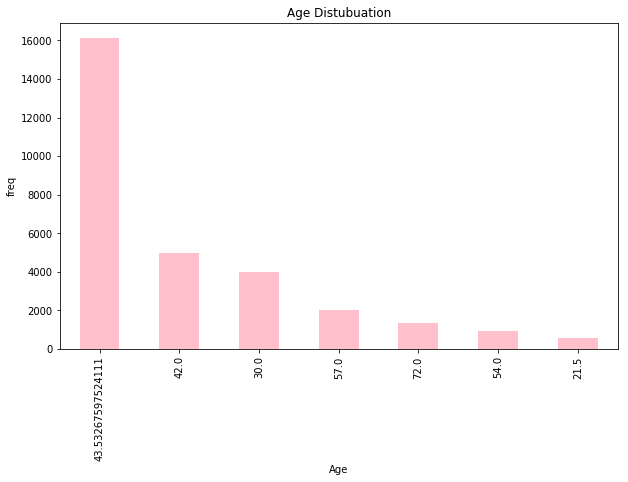

In [207]:
# check the age distubuation
foundation_review.reviewer_age.value_counts().plot(kind='bar',figsize=(10,6), color='pink')
plt.title('Age Distubuation');
plt.ylabel('freq');
plt.xlabel('Age');

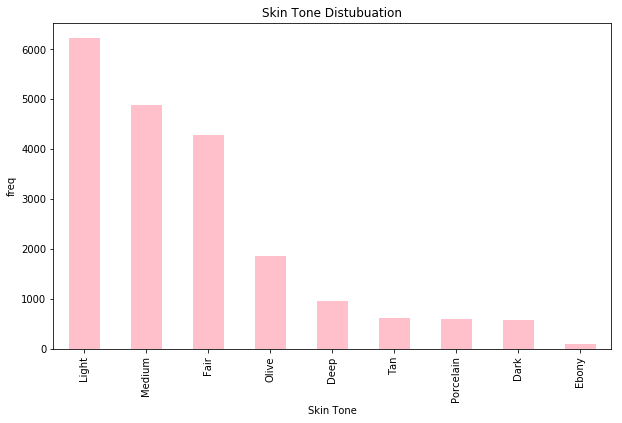

In [208]:
# get only the skin tone without NA 
sktone_df = foundation_review.reviewer_skin_tone.loc[foundation_review.reviewer_skin_tone != 'NA']


# check the skin tone distubuation
sktone_df.value_counts().plot(kind='bar',figsize=(10,6), color='pink')
plt.title('Skin Tone Distubuation');
plt.ylabel('freq');
plt.xlabel('Skin Tone');
# As we can see the most skin tone in this dataset is light 

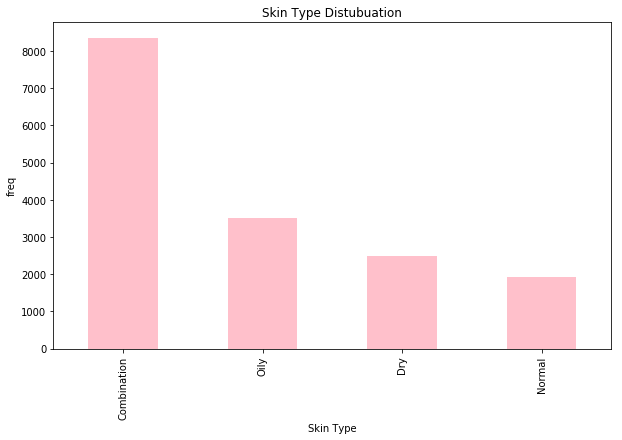

In [209]:
# get only the skin type without NA 
sktype_df = foundation_review.reviewer_skin_type.loc[foundation_review.reviewer_skin_type != 'NA']


# check the skin tone distubuation
sktype_df.value_counts().plot(kind='bar',figsize=(10,6), color='pink')
plt.title('Skin Type Distubuation');
plt.ylabel('freq');
plt.xlabel('Skin Type');
# As we can see the most skin Type in this dataset is combintion 

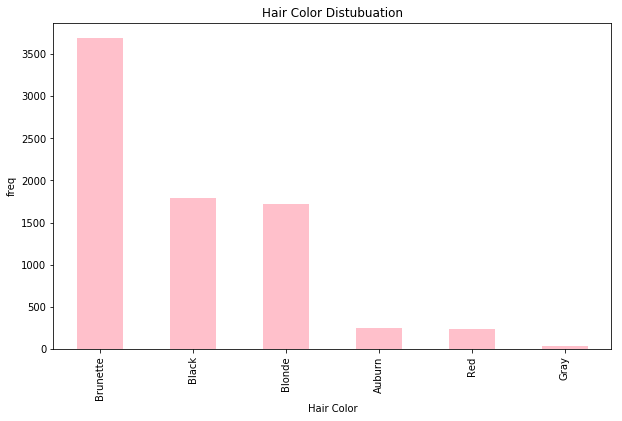

In [210]:
# get only the hair color without NA 
hcolor_df = foundation_review.reviewer_hair_color.loc[foundation_review.reviewer_hair_color != 'NA']


# check the skin tone distubuation
hcolor_df.value_counts().plot(kind='bar',figsize=(10,6), color='pink')
plt.title('Hair Color Distubuation');
plt.ylabel('freq');
plt.xlabel('Hair Color');
# As we can see the most Hair Color in this dataset is brunette 


## Preprocessing and Modeling
-----
Here I will start modeling. but firt I will Encode some columns. Then I will see the correlation 
between the columns and foundations names



In [211]:
# Endocde the foundation names in the two dataframe

# make dict with all founation names
found_name = {}

# loop to fill the dict with the founation as key and index as value
for i, name in enumerate(foundation_details.foundation_name):
    found_name[name] = i
    
# map the Encode
foundation_details['Encoded_foundation_name'] = foundation_details.foundation_name.map(found_name)
foundation_review['Encoded_foundation_name'] = foundation_review.foundation_name.map(found_name)


# Encode the hair color
EncodeHair_color= {'Auburn':0, 'Black':1, 'Blonde':2, 'Brunette':3, 'Gray':4, 'NA':5, 'Red':6}
foundation_review['EncodeHair_color'] = foundation_review.reviewer_hair_color.map(EncodeHair_color)

# Encode the skin type
EncodedSkin_type = {'Normal':0, 'Dry':1, 'Combination':2, 'Oily':3, 'Sensitive':4, 'NA': 5}
foundation_review['EncodedSkin_type'] = foundation_review.reviewer_skin_type.map(EncodedSkin_type)



# Encode the skin tone
EncodedSkin_tone = {'Dark':0, 'Deep':1, 'Ebony':2, 'Fair':3, 'Light':4, 'Medium':5, 'NA':6, 'Olive':7, 'Porcelain':8,
 'Tan':9}
foundation_review['EncodedSkin_tone'] = foundation_review.reviewer_skin_tone.map(EncodedSkin_tone)


# Encode the eye color
EncodedEye_color = {'Blue':0, 'Brown':1, 'Gray':2, 'Green':3, 'Hazel':4, 'NA':5}
foundation_review['EncodedEye_color'] = foundation_review.reviewer_eye_color.map(EncodedEye_color)



In [212]:
# look at the dataframe
foundation_review.head()

,foundation_brand,foundation_name,reviewer_nickname,reviewer_skin_color,reviewer_skin_color_pic,helpful,not_helpful,review_rank,reviewer_eye_color,reviewer_hair_color,...,reviewer_skin_type,foundation_review,r,g,b,Encoded_foundation_name,EncodeHair_color,EncodedSkin_type,EncodedSkin_tone,EncodedEye_color
0,FENTY BEAUTY by Rihanna,Pro Filt'r Soft Matte Longwear Foundation,cjspencer,Color: 100,https://www.sephora.com/productimages/sku/s192...,2,0,100.0,Blue,Black,...,Combination,I'm insanely pale and neutral so finding found...,254.331790,218.202160,187.435957,0,1,2,8,0
1,FENTY BEAUTY by Rihanna,Pro Filt'r Soft Matte Longwear Foundation,toriashley88,Color: 385,https://www.sephora.com/productimages/sku/s216...,33,1,100.0,Brown,Black,...,Combination,"Previously, I used 390, for the longest time, ...",209.928241,145.803241,86.652006,0,1,2,1,1
2,FENTY BEAUTY by Rihanna,Pro Filt'r Soft Matte Longwear Foundation,emilyrerwin,Color: 100,https://www.sephora.com/productimages/sku/s192...,119,6,100.0,Brown,Blonde,...,Combination,"As someone who is very VERY fair, I have alway...",254.331790,218.202160,187.435957,0,2,2,8,1
3,FENTY BEAUTY by Rihanna,Pro Filt'r Soft Matte Longwear Foundation,bookmagnet77,Color: 210,https://www.sephora.com/productimages/sku/s192...,221,12,100.0,Brown,Brunette,...,Oily,Let me say first that you need time to apply t...,244.929784,189.708333,147.353395,0,3,3,5,1
4,FENTY BEAUTY by Rihanna,Pro Filt'r Soft Matte Longwear Foundation,Darrianne,Color: 110,https://www.sephora.com/productimages/sku/s192...,30,2,80.0,Hazel,Blonde,...,Combination,First of all these shade range is awesome and ...,254.327932,219.854167,217.472994,0,2,2,8,4


In [252]:
# assign only the related columns
fr_spcolumns = foundation_review[['r','g', 'b', 'Encoded_foundation_name', 'EncodeHair_color',
                                   'reviewer_age', 'EncodedSkin_type', 'EncodedSkin_tone', 'EncodedEye_color']]


In [255]:
# look at the shape
fr_spcolumns.shape

(29999, 9)

In [256]:
# look at the correlation 
fr_spcolumns.corr()['Encoded_foundation_name'].abs().sort_values(ascending=False)[1:]

EncodedSkin_type    0.101632
r                   0.055198
g                   0.047112
EncodeHair_color    0.043974
EncodedEye_color    0.042282
b                   0.035606
EncodedSkin_tone    0.027344
reviewer_age        0.024515
Name: Encoded_foundation_name, dtype: float64

## Modeling 
---
Here I will use diffrent models to predcit the foundation.

In [257]:
# assign X, y
y = fr_spcolumns.pop('Encoded_foundation_name')
X = fr_spcolumns

In [268]:
# import
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

In [259]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [262]:
# LogisticRegression
lr = LogisticRegression()

# fit the model
lr.fit(X_train, y_train)

# see the socre
print(lr.score(X_train, y_train), lr.score(X_test, y_test))
      
# y pred
y_pred = lr.predict(X_test)

# see the socre for the predict 
metrics.accuracy_score(y_test, y_pred)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.17907462553891285 0.17226666666666668


0.17226666666666668

In [263]:
# LogisticRegressionCV
lr = LogisticRegressionCV()

# fit the model
lr.fit(X_train, y_train)

# see the socre
print(lr.score(X_train, y_train), lr.score(X_test, y_test))
      
# y pred
y_pred = lr.predict(X_test)

# see the socre for the predict 
metrics.accuracy_score(y_test, y_pred)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarnin

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3

0.16258500377794569 0.1624


0.1624

In [265]:
# DecisionTreeClassifier
dt = DecisionTreeClassifier()

# fit the model
dt.fit(X_train, y_train)

# see the socre
print(dt.score(X_train, y_train), dt.score(X_test, y_test))
      
# y pred
y_pred = dt.predict(X_test)

# see the socre for the predict 
metrics.accuracy_score(y_test, y_pred)

0.4046402062313881 0.3584


0.3584

In [269]:
# RandomForestClassifier
rf = RandomForestClassifier()

# fit the model
rf.fit(X_train, y_train)

# see the socre
print(rf.score(X_train, y_train), rf.score(X_test, y_test))
      
# y pred
y_pred = rf.predict(X_test)

# see the socre for the predict 
metrics.accuracy_score(y_test, y_pred)

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.4026401173385484 0.33226666666666665


0.33226666666666665

In [270]:
# ExtraTreesClassifier
ex = ExtraTreesClassifier()

# fit the model
ex.fit(X_train, y_train)

# see the socre
print(ex.score(X_train, y_train), ex.score(X_test, y_test))
      
# y pred
y_pred = ex.predict(X_test)

# see the socre for the predict 
metrics.accuracy_score(y_test, y_pred)

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.4046402062313881 0.3312


0.3312

# nlp on the  review
----
Here I did some work to extract the word cloud fro specific foundation

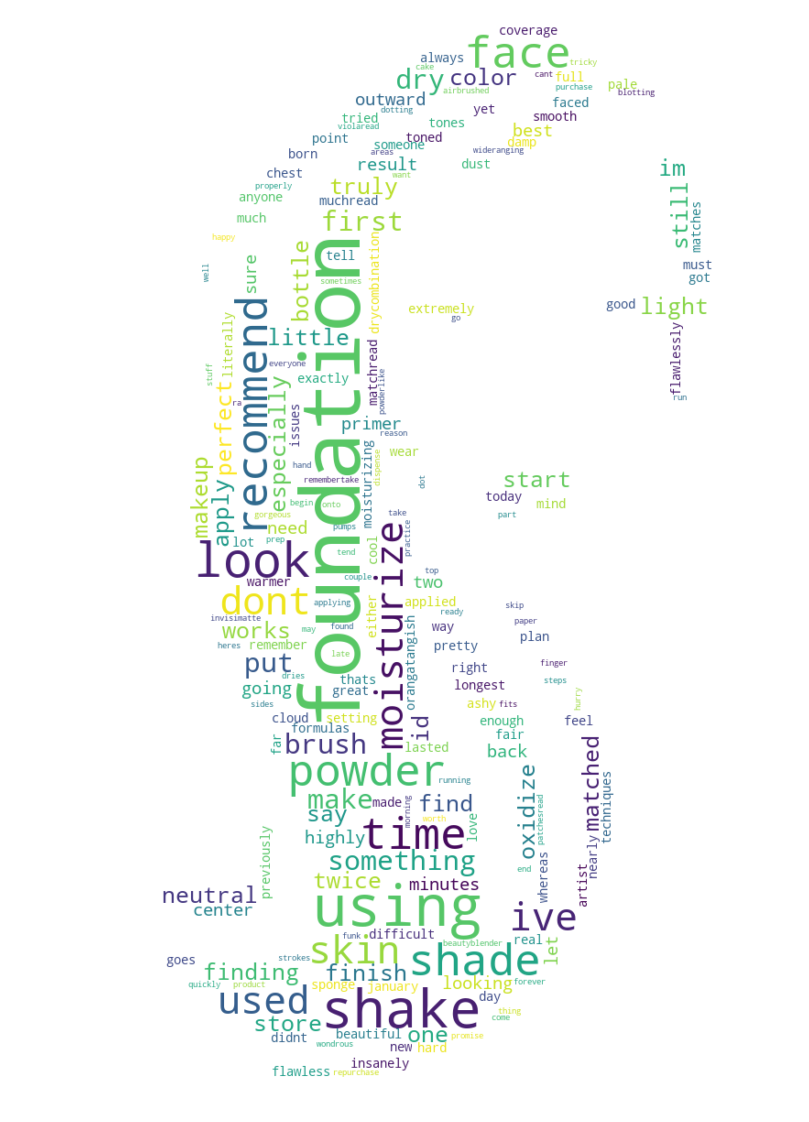

In [289]:
# get the details for specific foundation
df_one_foun = foundation_review.loc[foundation_review.Encoded_foundation_name == 0, :]

# number of characters 
df_one_foun['word_count'] = df_one_foun.foundation_review.apply(lambda x: len(str(x).split(" ")))

# lowercase
df_one_foun['foundation_review'] = df_one_foun['foundation_review'].apply(lambda x: " ".join(x.lower() for x in x.split()))

# removing the speical characters
df_one_foun['foundation_review'] = df_one_foun['foundation_review'].str.replace('[^\w\s]','')

# removing the stop word 
stop = stopwords.words('english')
df_one_foun['foundation_review'] = df_one_foun['foundation_review'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

# find the frq word
freq = pd.Series(' '.join(df_one_foun['foundation_review']).split()).value_counts()


comment_words = ''
for words in list(df_one_foun['foundation_review']): 
    comment_words = comment_words + words + ' '

d = getcwd()
## join all documents in corpus
text = comment_words

mask = np.array(Image.open(path.join(d, "makeup6.png")))
wc = WordCloud(background_color="white", max_words=1000, mask=mask,
           max_font_size=90, random_state=42)
wc.generate(text[:2200])
# create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize = (20, 20))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()